In [1]:
import pandas as pd

df = pd.read_csv('dataset/SeoulBikeData.csv')

In [2]:
df.info()

df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      8760 non-null   object 
 1   Rented Bike Count         8760 non-null   int64  
 2   Hour                      8760 non-null   int64  
 3   Temperature(C)            8760 non-null   float64
 4   Humidity(%)               8760 non-null   int64  
 5   Wind speed (m/s)          8760 non-null   float64
 6   Visibility (10m)          8760 non-null   int64  
 7   Dew point temperature(C)  8760 non-null   float64
 8   Rainfall(mm)              8760 non-null   float64
 9   Snowfall (cm)             8760 non-null   float64
 10  Seasons                   8760 non-null   object 
 11  Holiday                   8760 non-null   object 
 12  Functioning Day           8760 non-null   object 
dtypes: float64(5), int64(4), object(4)
memory usage: 889.8+ KB


,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,Winter,No Holiday,Yes


In [3]:
import pickle
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

base_date = pd.to_datetime('2017-12-01')

encoders = {
 "Seasons": LabelEncoder(),
 "Holiday": LabelEncoder(),
 "Functioning Day": LabelEncoder()
}

df['hour diff'] = (pd.to_datetime(df['Date'], format='%Y-%m-%d') + pd.to_timedelta(df['Hour'], unit='h') - base_date).dt.total_seconds() / 3600

for col, encoder in encoders.items():
    df[col] = encoder.fit_transform(df[col])

# pickle 파일로 저장
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)

In [4]:
df.head(3)

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,hour diff
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,3,1,1,0.0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,3,1,1,1.0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,3,1,1,2.0


In [5]:
from sklearn.model_selection import train_test_split

df[df.columns.drop("Date")] = df[df.columns.drop("Date")].astype('float64')

X, y = df.drop(['Rented Bike Count'], axis=1), df['Rented Bike Count']  # 타겟 컬럼
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)


test_datetime= X_test['Date'].astype('str') +"T"+ X_test['Hour'].astype('int').map(lambda s : "0"+str(s) if len(str(s)) == 1 else str(s))
X_train, X_test = X_train.drop('Date', axis=1), X_test.drop("Date", axis=1)
print(f'train shape (X, y): {X_train.shape}, {y_train.shape}')
print(f'test shape  (X, y): {X_test.shape}, {y_test.shape}')

train shape (X, y): (7008, 12), (7008,)
test shape  (X, y): (1752, 12), (1752,)


In [6]:
import mlflow
import mlflow.sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

import os

# MLflow 실험 설정
HOST = "http://mlflow.mlflow:5000"
EXPREIMENT_NAME = "Bike Rental Prediction"

os.environ['AWS_ACCESS_KEY_ID'] = 'admin'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'admin123'
os.environ['MLFLOW_S3_ENDPOINT_URL'] = "http://minio.minio"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'admin'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'admin1234567'

mlflow.set_tracking_uri(HOST)
mlflow.set_experiment(EXPREIMENT_NAME)
mlflow.sklearn.autolog()
mlflow.xgboost.autolog()
mlflow.enable_system_metrics_logging()

# 모델 목록
models = {
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(n_estimators=50, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=50, random_state=42)
}

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

features = list(X_train.columns)
color_palette = sns.color_palette("husl", len(features))
color_dict = dict(zip(features, color_palette))

def plot_feature_importance(model_name, feature_imp, color_dict=color_dict, top_n=10):
    plt.figure(figsize=(12, 6))
    
    top_features = feature_imp.nlargest(top_n, 'importance')
    
    bars = plt.bar(range(top_n), top_features['importance'], 
                   color=[color_dict[feat] for feat in top_features['feature']])
    
    plt.title(f'Top {top_n} Feature Importances - {model_name}', fontsize=15, pad=20)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Importance', fontsize=12)
    
    plt.xticks(range(top_n), top_features['feature'], rotation=45, ha='right')
    
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, 
                bar.get_height(), 
                f'{top_features["importance"].iloc[i]:.3f}',
                ha='center', va='bottom')
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    plt.savefig(f"{model_name}_feature_importance.png", dpi=300, bbox_inches='tight')
    mlflow.log_artifact(f"{model_name}_feature_importance.png")
    plt.show()
    plt.close()

2025/06/30 02:00:48 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.
2025/06/30 02:00:48 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


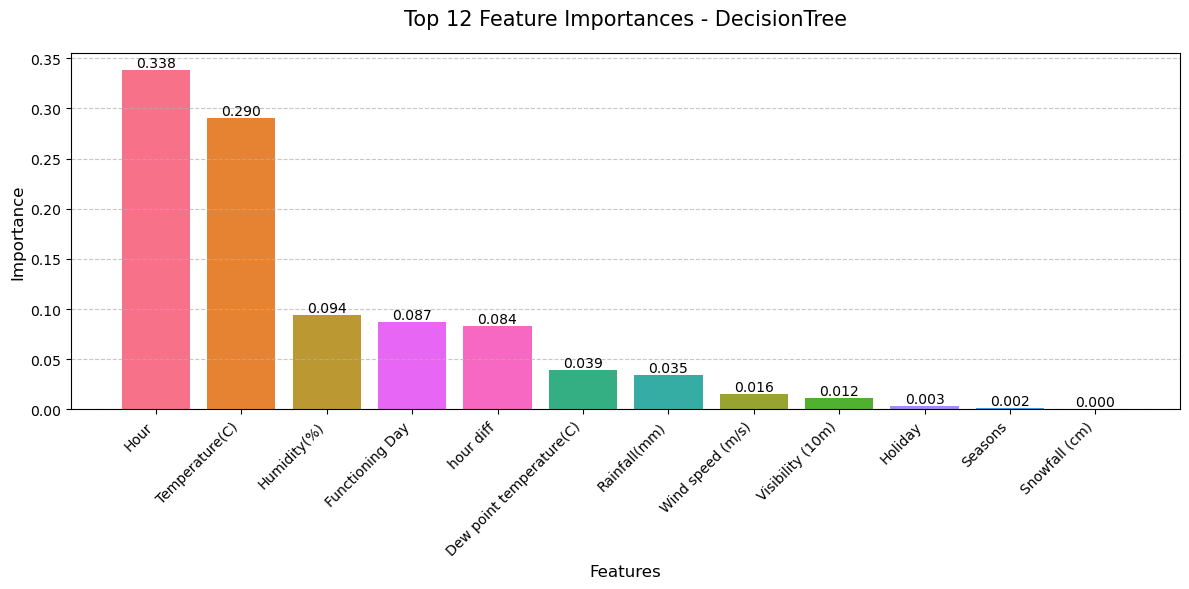

DecisionTree - MSE: 107377.5451, RMSE: 327.6851, R2: 0.7423
🏃 View run DecisionTree at: http://mlflow.mlflow:5000/#/experiments/1/runs/10f060a3995f4966b2a4d2213403c25e
🧪 View experiment at: http://mlflow.mlflow:5000/#/experiments/1


2025/06/30 02:00:56 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/06/30 02:00:57 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2025/06/30 02:00:57 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.
2025/06/30 02:00:57 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


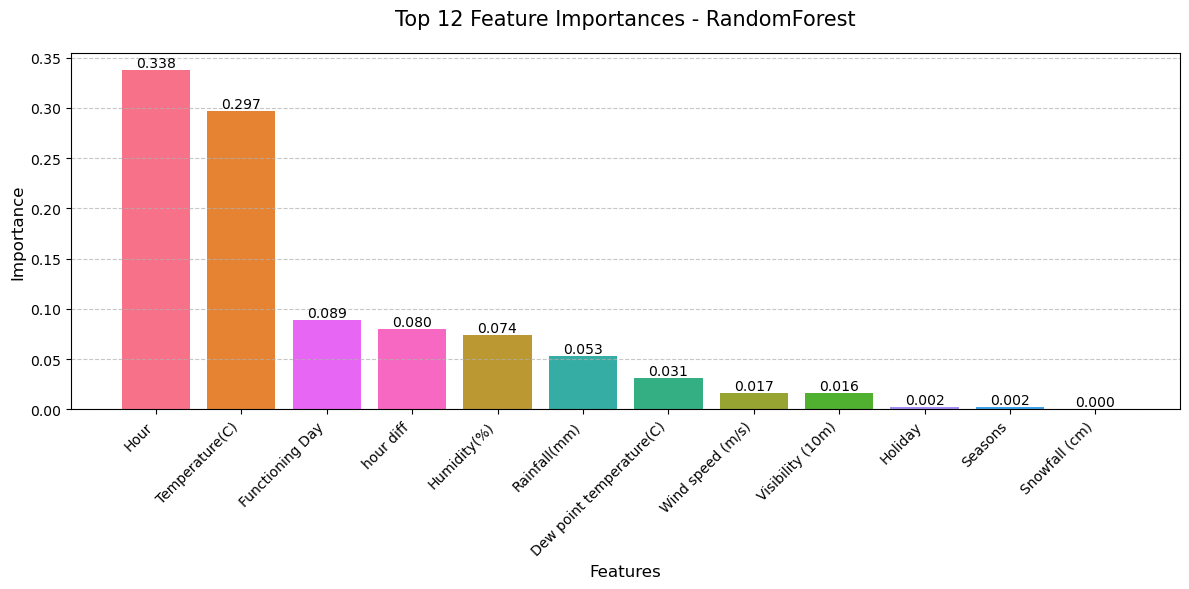

RandomForest - MSE: 50821.2174, RMSE: 225.4356, R2: 0.8780
🏃 View run RandomForest at: http://mlflow.mlflow:5000/#/experiments/1/runs/8d9d3a5edb77479e9962dafd31ac1d61
🧪 View experiment at: http://mlflow.mlflow:5000/#/experiments/1


2025/06/30 02:01:07 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/06/30 02:01:07 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2025/06/30 02:01:07 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.
2025/06/30 02:01:07 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2025/06/30 02:01:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/30 02:01:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [02:01:09] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."


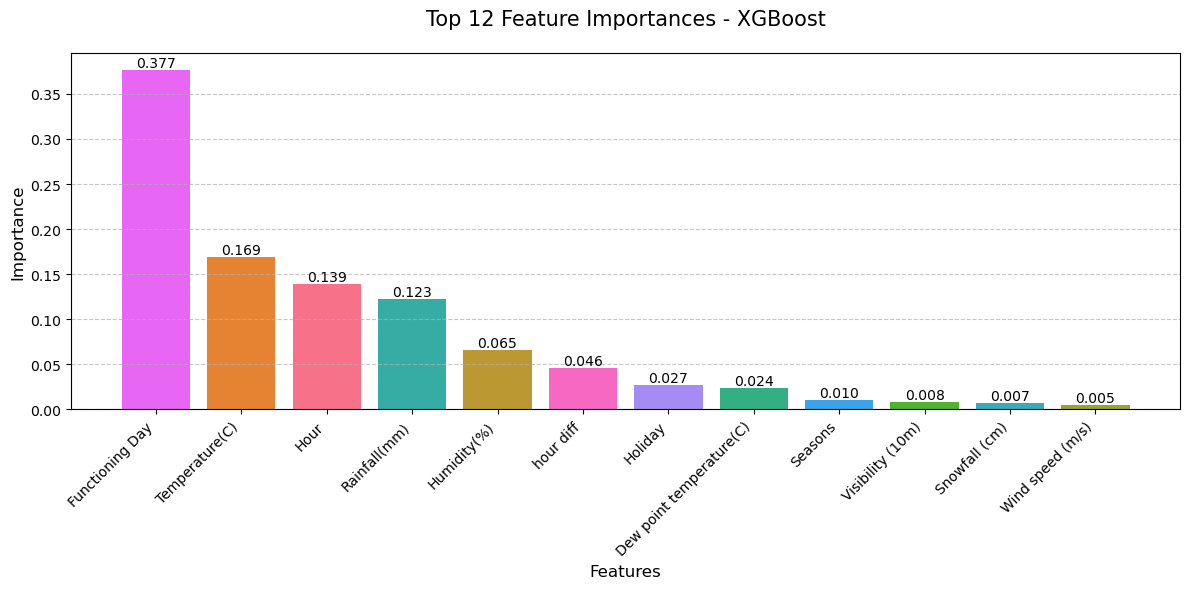

XGBoost - MSE: 47491.7502, RMSE: 217.9260, R2: 0.8860
🏃 View run XGBoost at: http://mlflow.mlflow:5000/#/experiments/1/runs/482d0335742346b7a7e1a2d5df074eca
🧪 View experiment at: http://mlflow.mlflow:5000/#/experiments/1


2025/06/30 02:01:15 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/06/30 02:01:15 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [10]:
# 각 모델에 대해 학습 및 평가
for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        # ... (이전 코드와 동일) ...
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        # MLflow에 메트릭 기록
        mlflow.log_metric("MSE", mse)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("R2", r2)
        
        # 모델 파라미터 기록
        mlflow.log_params(model.get_params())
        # mlflow.sklearn.log_model(sk_model=model, name=model_name)
        
        importances = None
        if model_name == "RandomForest":
            importances = model.feature_importances_
        elif model_name == "XGBoost":
            importances = model.feature_importances_
        elif model_name == "DecisionTree":
            importances = model.feature_importances_
        
        if importances is not None:
            feature_imp = pd.DataFrame({
                'feature': X_train.columns,
                'importance': importances
            }).sort_values('importance', ascending=False)

            feature_imp.to_csv(f"{model_name}_feature_importance.csv", index=False)
            mlflow.log_artifact(f"{model_name}_feature_importance.csv")

            plot_feature_importance(model_name, feature_imp, top_n=len(features))
        
        print(f"{model_name} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

In [11]:
X_test, y_test, test_datetime= X_test.sort_index(), y_test.sort_index(), test_datetime.sort_index()

2025/06/30 02:01:17 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.
2025/06/30 02:01:17 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


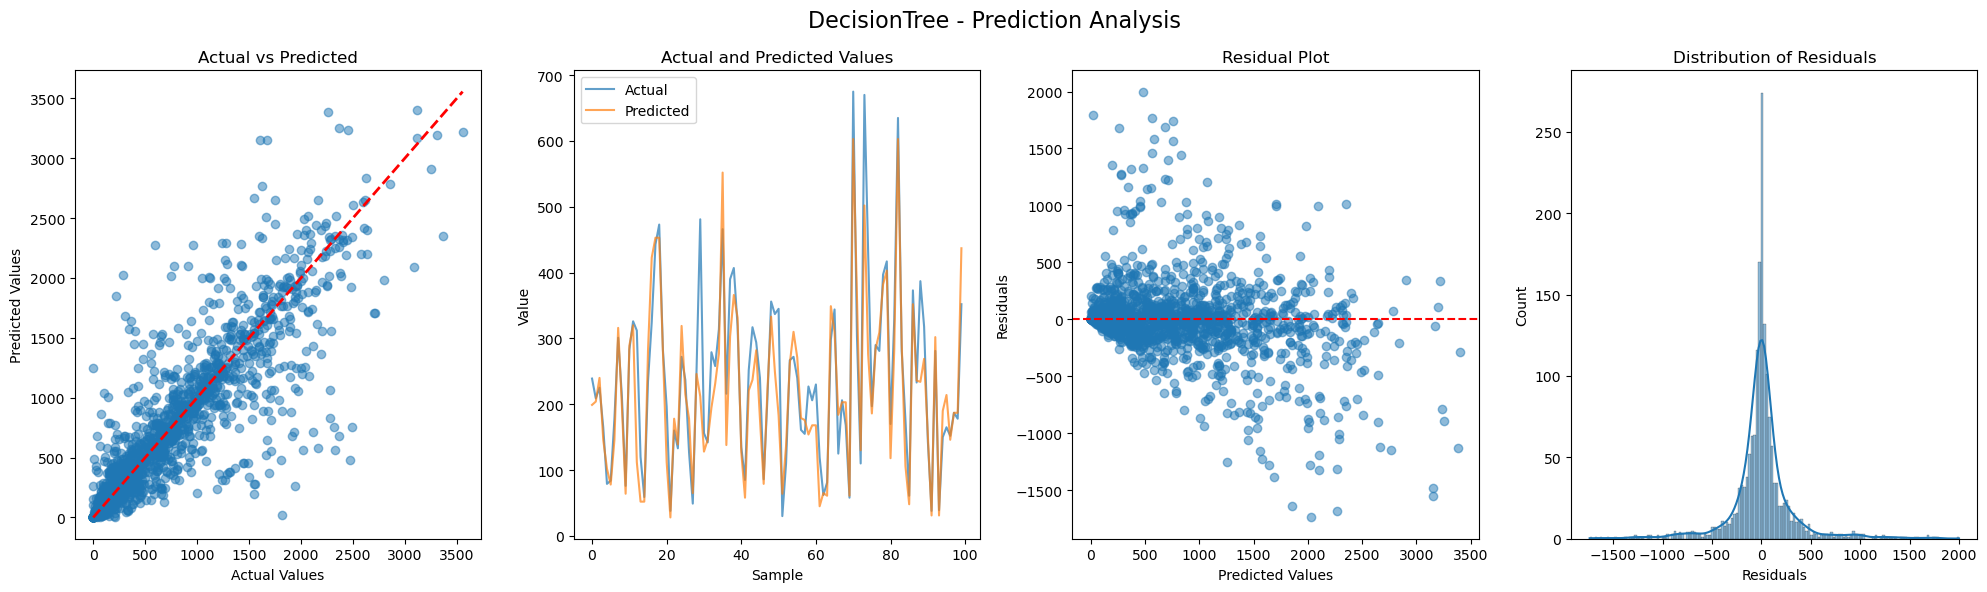

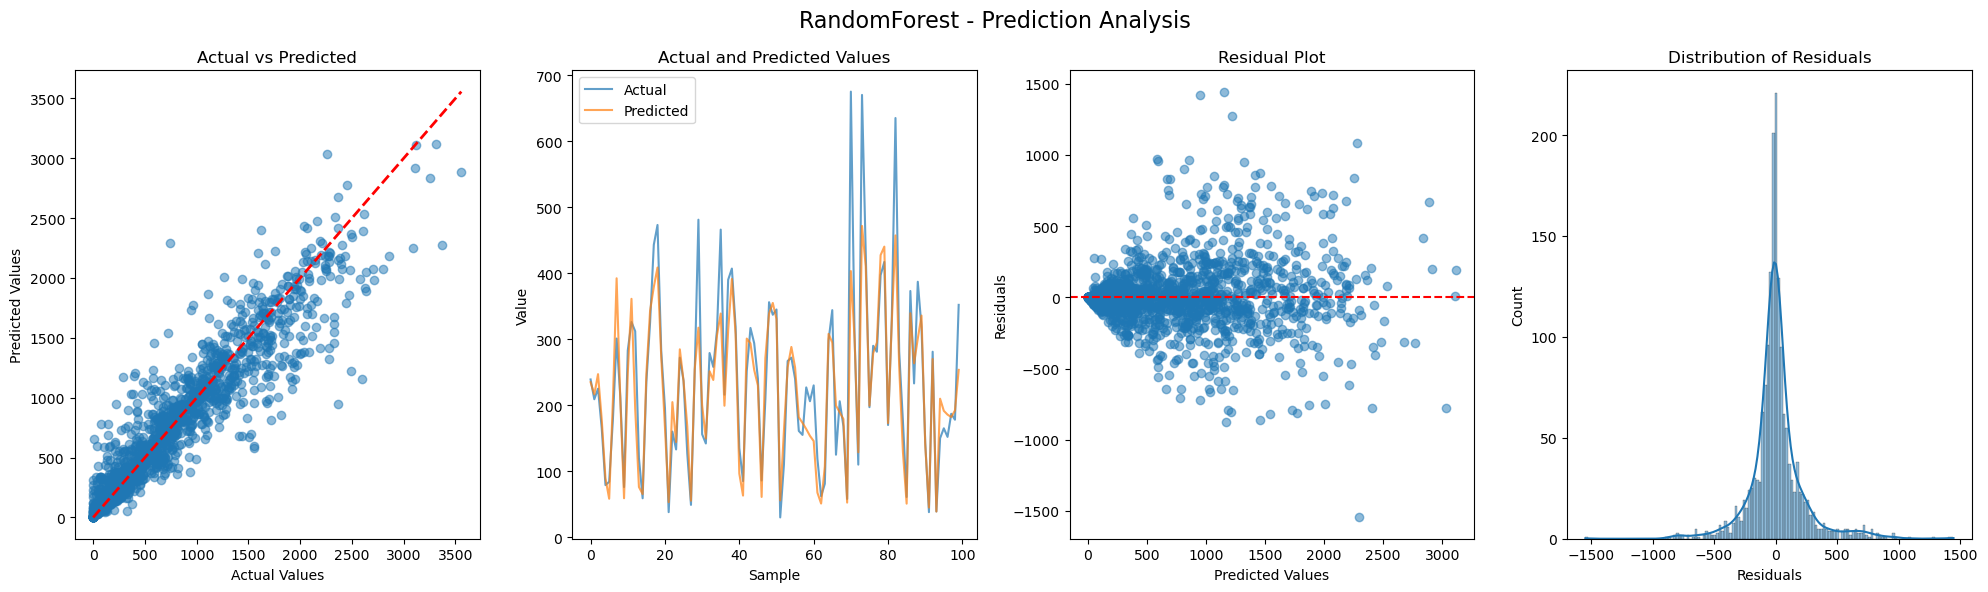

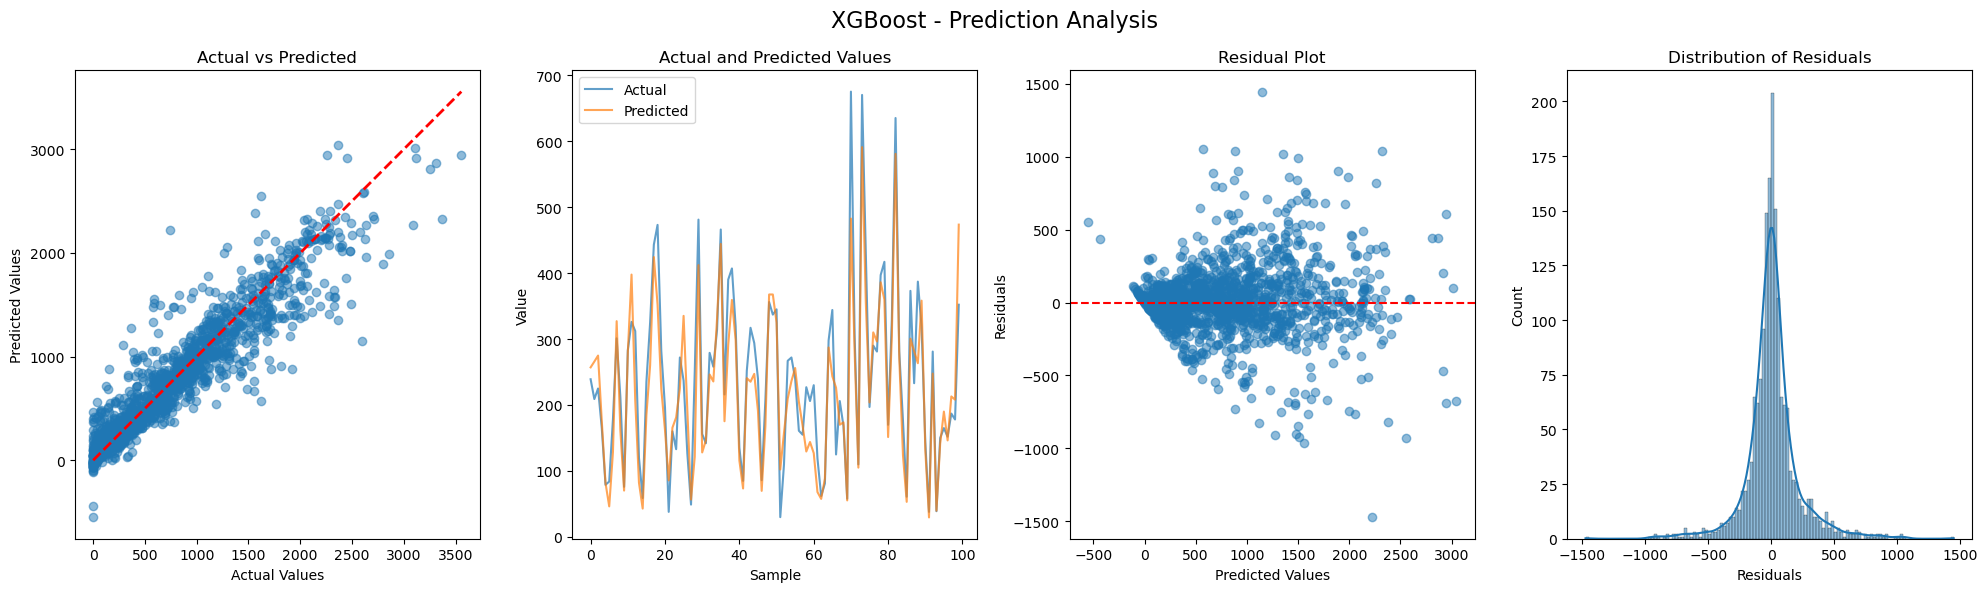

🏃 View run fearless-shrike-95 at: http://mlflow.mlflow:5000/#/experiments/1/runs/b8cf4ca33c194a239b24cf2b91225177
🧪 View experiment at: http://mlflow.mlflow:5000/#/experiments/1


2025/06/30 02:01:22 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/06/30 02:01:22 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [12]:
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6))
    
    # 1. 산점도
    ax1.scatter(y_test, y_pred, alpha=0.5)
    ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax1.set_xlabel('Actual Values')
    ax1.set_ylabel('Predicted Values')
    ax1.set_title('Actual vs Predicted')
    
    # 2. 실제 vs 예측 선 그래프
    ax2.plot(range(len(test_datetime[100:200])), y_test[100:200], label='Actual', alpha=0.7)
    ax2.plot(range(len(test_datetime[100:200])), y_pred[100:200], label='Predicted', alpha=0.7)
    ax2.set_xlabel('Sample')
    ax2.set_ylabel('Value')
    ax2.set_title('Actual and Predicted Values')
    ax2.legend()

    # 3. 잔차 플롯
    residuals = y_test - y_pred
    ax3.scatter(y_pred, residuals, alpha=0.5)
    ax3.axhline(y=0, color='r', linestyle='--')
    ax3.set_xlabel('Predicted Values')
    ax3.set_ylabel('Residuals')
    ax3.set_title('Residual Plot')

    # 4. 잔차 분포
    sns.histplot(residuals, ax=ax4, kde=True)
    ax4.set_xlabel('Residuals')
    ax4.set_ylabel('Count')
    ax4.set_title('Distribution of Residuals')
    
    
    plt.suptitle(f'{model_name} - Prediction Analysis', fontsize=16)
    plt.tight_layout()
    
    # 저장 및 표시
    plt.savefig(f"{model_name}_prediction_analysis.png", dpi=300, bbox_inches='tight')
    mlflow.log_artifact(f"{model_name}_prediction_analysis.png")
    
    # Jupyter Notebook에 표시
    plt.show()
    
    # 메모리 정리
    plt.close()

mlflow.end_run()

In [ ]:
registered_model_name = "bike_rental_123"
version = 2

loaded_model = mlflow.xgboost.load_model(f"models:/{registered_model_name}/{version}")

In [9]:
# create minio bucket

from utils import create_minio_bucket, upload_directory_to_minio
from minio import Minio
from minio.error import S3Error
minio_client = Minio(
    endpoint="minio.minio",  # MinIO 서버 주소
    access_key="admin",
    secret_key="admin123",
    secure=False
)
create_minio_bucket(minio_client, "dataset", "spark-jobs", "spark", "mlflow-artifact")
upload_directory_to_minio(minio_client, "dataset", "dataset")
upload_directory_to_minio(minio_client, "pipeline/01_preprocessing.py", "spark-jobs")
upload_directory_to_minio(minio_client, "label_encoders.pkl", "dataset")

MinIO bucket 'dataset' already exists
MinIO bucket 'spark-jobs' already exists
MinIO bucket 'spark' already exists
MinIO bucket 'mlflow-artifact' created successfully
Uploaded /home/jovyan/dataset/weather_data_random_recent.csv to dataset/weather_data_random_recent.csv
Uploaded /home/jovyan/dataset/weather_data_202412.csv to dataset/weather_data_202412.csv
Uploaded /home/jovyan/dataset/weather_data_random_more.csv to dataset/weather_data_random_more.csv
Uploaded /home/jovyan/dataset/rental_bike_count.csv to dataset/rental_bike_count.csv
Uploaded /home/jovyan/dataset/SeoulBikeData.csv to dataset/SeoulBikeData.csv
Uploaded 01_preprocessing.py to spark-jobs/01_preprocessing.py
Uploaded label_encoders.pkl to dataset/label_encoders.pkl
